

# **Tacotron 2 Training (Kaggle Notebook)**
---
Tacotron 2 | **Created by ColdFir3#9543 (Michael)**

**MAKE SURE 'GPU' HAS BEEN SELECTED AS THE ACCELERATOR IN THE NOTEBOOK SETTINGS**

*UPDATED 28/09/21 VERSION 13: Fixed the issue with not being able to load in previous models to continue training*

*UPDATED 30/09/21 VERSION 14: Made instructions a little more clearer to understand and made the code a little easier to use*

*UPDATED 09/10/21 VERSION 15: Fixed bugs*

*UPDATED 23/10/21 VERSION 16: Tweaked the requirements list*

---
# TRAINING INSTRUCTIONS

* **Make sure to make your own version of this notebook for each new model**

* Transcription file should look be in this format for each wav (WITH PUNCTUATION): ```wavs/1.wav|[Text here].```

* Dataset WAVS format should be: **22050HZ, 16 bit PCM, Mono**

* **ONLY IMPORT YOUR DATASET ONCE** *(should consist of a folder called 'wavs' with all audio clips and another file for your transcriptions)*

Example: 

```
Kaggle Dataset/
          ├──wavs/
          │    ├──1.wav
          │    ├──2.wav
          │    ├──3.wav
          │    └──etc
          └──transcription.txt
```
* **MAKE SURE TO RUN ALL AND ENTER REQUIRED DATA**

* ***(VERY IMPORTANT)*** Once your model has been trained **DO NOT FORGET TO SAVE VERSION AND GO TO 'ADVANCED' AND CHECK 'ALWAYS SAVE OUTPUT'** so you do NOT LOSE progress
---
# CONTINUING TO TRAIN?
* If returning back to continue training your model **MAKE SURE TO RUN ALL AND ENTER REQUIRED DATA**

* Import your Model as a "dataset" **SEPERATELY** from the training dataset

* **DON'T MAKE ANY OF THE SETTINGS DIFFERENT FROM YOUR PREVIOUS TRAINING**

* Recommended to name your "input" for your AI Model to be the same name as the model itself **(WILL SAVE LOTS OF TROUBLE AT STEP 5.5)**

* ***(VERY IMPORTANT)*** Once your model has been trained **DO NOT FORGET TO SAVE VERSION USING 'QUICK SAVE' AS THE OPTION AND GO TO 'ADVANCED' AND CHECK 'ALWAYS SAVE OUTPUT'** so you do NOT LOSE progress

---

# (Optional) Check GPU type

In [ ]:
!nvidia-smi -L

---

# 1 Run the below block of code to download and install Tacotron 2 and dependancies

In [ ]:
!pip install tensorflow==1.15.2
!pip install -q unidecode tensorboardX
!git clone -q https://github.com/NVIDIA/tacotron2
%cd tacotron2
!pip install inflect
!git submodule init
!git submodule update
!apt-get install pv
!apt-get install jq
!pip install gdown

%matplotlib inline
import os
import time
import argparse
import math
from distutils.dir_util import copy_tree
from numpy import finfo

import torch
from distributed import apply_gradient_allreduce
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import DataLoader

from model import Tacotron2
from data_utils import TextMelLoader, TextMelCollate
from loss_function import Tacotron2Loss
from logger import Tacotron2Logger
from hparams import create_hparams
 
import random
import numpy as np

import layers
from utils import load_wav_to_torch, load_filepaths_and_text
from text import text_to_sequence
from math import e
from tqdm.notebook import tqdm # Modern Notebook TQDM
from distutils.dir_util import copy_tree
import matplotlib.pylab as plt

def create_mels():
    print("Generating Mels")
    stft = layers.TacotronSTFT(
                hparams.filter_length, hparams.hop_length, hparams.win_length,
                hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
                hparams.mel_fmax)
    def save_mel(filename):
        audio, sampling_rate = load_wav_to_torch(filename)
        if sampling_rate != stft.sampling_rate:
            raise ValueError("{} {} SR doesn't match target {} SR".format(filename, 
                sampling_rate, stft.sampling_rate))
        audio_norm = audio / hparams.max_wav_value
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        melspec = stft.mel_spectrogram(audio_norm)
        melspec = torch.squeeze(melspec, 0).cpu().numpy()
        np.save(filename.replace('.wav', ''), melspec)

    import glob
    wavs = glob.glob('/wavs/*.wav')
    for i in tqdm(wavs):
        save_mel(i)


def reduce_tensor(tensor, n_gpus):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.reduce_op.SUM)
    rt /= n_gpus
    return rt


def init_distributed(hparams, n_gpus, rank, group_name):
    assert torch.cuda.is_available(), "Distributed mode requires CUDA."
    print("Initializing Distributed")

    # Set cuda device so everything is done on the right GPU.
    torch.cuda.set_device(rank % torch.cuda.device_count())

    # Initialize distributed communication
    dist.init_process_group(
        backend=hparams.dist_backend, init_method=hparams.dist_url,
        world_size=n_gpus, rank=rank, group_name=group_name)

    print("Done initializing distributed")


def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = TextMelLoader(hparams.validation_files, hparams)
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn


def prepare_directories_and_logger(output_directory, log_directory, rank):
    if rank == 0:
        if not os.path.isdir(output_directory):
            os.makedirs(output_directory)
            os.chmod(output_directory, 0o775)
        logger = Tacotron2Logger(os.path.join(output_directory, log_directory))
    else:
        logger = None
    return logger


def load_model(hparams):
    model = Tacotron2(hparams).cuda()
    if hparams.fp16_run:
        model.decoder.attention_layer.score_mask_value = finfo('float16').min

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    return model


def warm_start_model(checkpoint_path, model, ignore_layers):
    assert os.path.isfile(checkpoint_path)
    print("Warm starting model from checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_dict = checkpoint_dict['state_dict']
    if len(ignore_layers) > 0:
        model_dict = {k: v for k, v in model_dict.items()
                      if k not in ignore_layers}
        dummy_dict = model.state_dict()
        dummy_dict.update(model_dict)
        model_dict = dummy_dict
    model.load_state_dict(model_dict)
    return model


def load_checkpoint(checkpoint_path, model, optimizer):
    assert os.path.isfile(checkpoint_path)
    print("Loading checkpoint '{}'".format(checkpoint_path))
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint_dict['state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer'])
    learning_rate = checkpoint_dict['learning_rate']
    iteration = checkpoint_dict['iteration']
    print("Loaded checkpoint '{}' from iteration {}" .format(
        checkpoint_path, iteration))
    return model, optimizer, learning_rate, iteration


def save_checkpoint(model, optimizer, learning_rate, iteration, filepath):
    print("Saving model and optimizer state at iteration {} to {}".format(
        iteration, filepath))
    try:
        torch.save({'iteration': iteration,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'learning_rate': learning_rate}, filepath)
    except KeyboardInterrupt:
        print("interrupt received while saving, waiting for save to complete.")
        torch.save({'iteration': iteration,'state_dict': model.state_dict(),'optimizer': optimizer.state_dict(),'learning_rate': learning_rate}, filepath)
    print("Model Saved")

def plot_alignment(alignment, info=None):
    %matplotlib inline
    fig, ax = plt.subplots(figsize=(int(alignment_graph_width/100), int(alignment_graph_height/100)))
    im = ax.imshow(alignment, cmap='inferno', aspect='auto', origin='lower',
                   interpolation='none')
    ax.autoscale(enable=True, axis="y", tight=True)
    fig.colorbar(im, ax=ax)
    xlabel = 'Decoder timestep'
    if info is not None:
        xlabel += '\n\n' + info
    plt.xlabel(xlabel)
    plt.ylabel('Encoder timestep')
    plt.tight_layout()
    fig.canvas.draw()
    plt.show()

def validate(model, criterion, valset, iteration, batch_size, n_gpus,
             collate_fn, logger, distributed_run, rank, epoch, start_eposh, learning_rate):
    """Handles all the validation scoring and printing"""
    model.eval()
    with torch.no_grad():
        val_sampler = DistributedSampler(valset) if distributed_run else None
        val_loader = DataLoader(valset, sampler=val_sampler, num_workers=1,
                                shuffle=False, batch_size=batch_size,
                                pin_memory=False, collate_fn=collate_fn)

        val_loss = 0.0
        for i, batch in enumerate(val_loader):
            x, y = model.parse_batch(batch)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            if distributed_run:
                reduced_val_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_val_loss = loss.item()
            val_loss += reduced_val_loss
        val_loss = val_loss / (i + 1)

    model.train()
    if rank == 0:
        print("Epoch: {} Validation loss {}: {:9f}  Time: {:.1f}m LR: {:.6f}".format(epoch, iteration, val_loss,(time.perf_counter()-start_eposh)/60, learning_rate))
        logger.log_validation(val_loss, model, y, y_pred, iteration)
        if hparams.show_alignments:
            %matplotlib inline
            _, mel_outputs, gate_outputs, alignments = y_pred
            idx = random.randint(0, alignments.size(0) - 1)
            plot_alignment(alignments[idx].data.cpu().numpy().T)

def train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus,
          rank, group_name, hparams, log_directory2):
    """Training and validation logging results to tensorboard and stdout

    Params
    ------
    output_directory (string): directory to save checkpoints
    log_directory (string) directory to save tensorboard logs
    checkpoint_path(string): checkpoint path
    n_gpus (int): number of gpus
    rank (int): rank of current gpu
    hparams (object): comma separated list of "name=value" pairs.
    """
    if hparams.distributed_run:
        init_distributed(hparams, n_gpus, rank, group_name)

    torch.manual_seed(hparams.seed)
    torch.cuda.manual_seed(hparams.seed)

    model = load_model(hparams)
    learning_rate = hparams.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                 weight_decay=hparams.weight_decay)

    if hparams.fp16_run:
        from apex import amp
        model, optimizer = amp.initialize(
            model, optimizer, opt_level='O2')

    if hparams.distributed_run:
        model = apply_gradient_allreduce(model)

    criterion = Tacotron2Loss()

    logger = prepare_directories_and_logger(
        output_directory, log_directory, rank)

    train_loader, valset, collate_fn = prepare_dataloaders(hparams)

    # Load checkpoint if one exists
    iteration = 0
    epoch_offset = 0
    if checkpoint_path is not None and os.path.isfile(checkpoint_path):
        if warm_start:
            model = warm_start_model(
                checkpoint_path, model, hparams.ignore_layers)
        else:
            model, optimizer, _learning_rate, iteration = load_checkpoint(
                checkpoint_path, model, optimizer)
            if hparams.use_saved_learning_rate:
                learning_rate = _learning_rate
            iteration += 1  # next iteration is iteration + 1
            epoch_offset = max(0, int(iteration / len(train_loader)))
    else:
      os.path.isfile("pretrained_model")
#       %cd /kaggle/working
#       !/output/kaggle/working/tacotron2/megadown.sh https://mega.nz/#!WXY3RILA!KyoGHtfB_sdhmLFoykG2lKWhh0GFdwMkk7OwAjpQHRo --o pretrained_model
      !gdown https://drive.google.com/uc?id=1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA -O pretrained_model
#       %cd tacotron2
      model = warm_start_model("pretrained_model", model, hparams.ignore_layers)
      # download LJSpeech pretrained model if no checkpoint already exists
    
    start_eposh = time.perf_counter()
    learning_rate = 0.0
    model.train()
    is_overflow = False
    # ================ MAIN TRAINNIG LOOP! ===================
    for epoch in tqdm(range(epoch_offset, hparams.epochs)):
        print("\nStarting Epoch: {} Iteration: {}".format(epoch, iteration))
        start_eposh = time.perf_counter() # eposh is russian, not a typo
        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
            start = time.perf_counter()
            if iteration < hparams.decay_start: learning_rate = hparams.A_
            else: iteration_adjusted = iteration - hparams.decay_start; learning_rate = (hparams.A_*(e**(-iteration_adjusted/hparams.B_))) + hparams.C_
            learning_rate = max(hparams.min_learning_rate, learning_rate) # output the largest number
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

            model.zero_grad()
            x, y = model.parse_batch(batch)
            y_pred = model(x)

            loss = criterion(y_pred, y)
            if hparams.distributed_run:
                reduced_loss = reduce_tensor(loss.data, n_gpus).item()
            else:
                reduced_loss = loss.item()
            if hparams.fp16_run:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if hparams.fp16_run:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    amp.master_params(optimizer), hparams.grad_clip_thresh)
                is_overflow = math.isnan(grad_norm)
            else:
                grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)

            optimizer.step()

            if not is_overflow and rank == 0:
                duration = time.perf_counter() - start
                logger.log_training(
                    reduced_loss, grad_norm, learning_rate, duration, iteration)
                #print("Batch {} loss {:.6f} Grad Norm {:.6f} Time {:.6f}".format(iteration, reduced_loss, grad_norm, duration), end='\r', flush=True)

            iteration += 1
        validate(model, criterion, valset, iteration,
                 hparams.batch_size, n_gpus, collate_fn, logger,
                 hparams.distributed_run, rank, epoch, start_eposh, learning_rate)
        save_checkpoint(model, optimizer, learning_rate, iteration, checkpoint_path)
        if log_directory2 != None:
            copy_tree(log_directory, log_directory2)
def check_dataset(hparams):
    from utils import load_wav_to_torch, load_filepaths_and_text
    import os
    import numpy as np
    def check_arr(filelist_arr):
        for i, file in enumerate(filelist_arr):
            if len(file) > 2:
                print("|".join(file), "\nhas multiple '|', this may not be an error.")
            if hparams.load_mel_from_disk and '.wav' in file[0]:
                print("[WARNING]", file[0], " in filelist while expecting .npy .")
            else:
                if not hparams.load_mel_from_disk and '.npy' in file[0]:
                    print("[WARNING]", file[0], " in filelist while expecting .wav .")
            if (not os.path.exists(file[0])):
                print("|".join(file), "\n[WARNING] does not exist.")
            if len(file[1]) < 3:
                print("|".join(file), "\n[info] has no/very little text.")
            if not ((file[1].strip())[-1] in r"!?,.;:"):
                print("|".join(file), "\n[info] has no ending punctuation.")
            mel_length = 1
            if hparams.load_mel_from_disk and '.npy' in file[0]:
                melspec = torch.from_numpy(np.load(file[0], allow_pickle=True))
                mel_length = melspec.shape[1]
            if mel_length == 0:
                print("|".join(file), "\n[WARNING] has 0 duration.")
    print("Checking Training Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.training_files) # get split lines from training_files text file.
    check_arr(audiopaths_and_text)
    print("Checking Validation Files")
    audiopaths_and_text = load_filepaths_and_text(hparams.validation_files) # get split lines from validation_files text file.
    check_arr(audiopaths_and_text)
    print("Finished Checking")

warm_start=False
n_gpus=1
rank=0
group_name=None

# ---- DEFAULT PARAMETERS DEFINED HERE ----
hparams = create_hparams()
model_filename = 'current_model'
hparams.training_files = "filelists/clipper_train_filelist.txt"
hparams.validation_files = "filelists/clipper_val_filelist.txt"
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1
hparams.decay_start = 15000
hparams.A_ = 5e-4
hparams.B_ = 8000
hparams.C_ = 0
hparams.min_learning_rate = 1e-5
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000
hparams.batch_size = 32
hparams.load_mel_from_disk = True
hparams.ignore_layers = []
hparams.epochs = 10000
torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

data_path = 'wavs'
!mkdir {data_path}

---

# 2 Create file lists from train and validation sets
Enter the name of your dataset and the name of your training transcription

In [ ]:
# Variables
dataset_name = "none"
training_list_name = "none"

# Inputs
while dataset_name == "none":
    dataset_name = input("What is the name of your dataset?: ")

while training_list_name == "none":
    training_list_name = input("What is the name of your training transcription file (add file extention: eg .txt)?: ")

# Training list
with open(f"../../input/{dataset_name}/{training_list_name}") as f:
    with open(f"filelists/{training_list_name}", "w") as f1:
        for line in f:
            f1.write(f'/'+line)

# User Completion
print("Done, text file has been copied in the right location.")

---

# 3 Setting Model Parameters
Enter your model name and your EPOCH limit to train toward

In [ ]:
model_filename = "none"
while model_filename == "none":
    model_filename = input("What is your desired model name?: ")

Training_file = f"filelists/{training_list_name}"
    
hparams.training_files = Training_file
hparams.validation_files = Training_file

# hparams to Tune
hparams.p_attention_dropout=0.1
hparams.p_decoder_dropout=0.1

# Learning Rate
hparams.decay_start = 15000         # wait till decay_start to start decaying learning rate
hparams.A_ = 5e-4                   # Start/Max Learning Rate
hparams.B_ = 8000                   # Decay Rate
hparams.C_ = 0                      # Shift learning rate equation by this value
hparams.min_learning_rate = 1e-5    # Min Learning Rate

# Quality of Life
generate_mels = True
hparams.show_alignments = True
alignment_graph_height = 600
alignment_graph_width = 1000

#Your batch size, lower if you don't have enough ram.
hparams.batch_size = 14 #18
hparams.load_mel_from_disk = True
hparams.ignore_layers = [] # Layers to reset (None by default, other than foreign languages this param can be ignored)

hparams.epochs = -1
while hparams.epochs <= -1:
    hparams.epochs = int(input("Your total epochs to train to (recommended: 250): "))

torch.backends.cudnn.enabled = hparams.cudnn_enabled
torch.backends.cudnn.benchmark = hparams.cudnn_benchmark

output_directory = '../outdir'
log_directory = '/logs' # Location to save Log files locally
log_directory2 = '../outdir/logs' # Location to copy log files (done at the end of each epoch to cut down on I/O)
checkpoint_path = output_directory+(r'/')+model_filename

# User Completion
print("Done, Settings applied")

---

# 4 Move files from Dataset to working directory

In [ ]:
os.system(f'cp -a ../../input/{dataset_name}/wavs /')
print("Files have successfully been copied over")

---

# 5 Convert WAV files into Mel-Spectograms and Checks missing files

In [ ]:
print("Generating mels")
if generate_mels:
    create_mels()

print("Checking for missing files")
# ---- Replace .wav with .npy in filelists ----
!sed -i -- 's,.wav|,.npy|,g' {hparams.training_files}; sed -i -- 's,.wav|,.npy|,g' {hparams.validation_files}

check_dataset(hparams)

---

# **(CONTINUING TO TRAIN?)** 5.5 Transfer Model into the working directory

In [ ]:
CONTINUEQ = input("Are you continuing to train your model? [Y/N]: ").upper()
while CONTINUEQ not in ("Y","N"):
    CONTINUEQ = input("Please only enter Y or N\nAre you continuing to train your model? [Y/N]: ")

if CONTINUEQ == "Y":
    os.system('mkdir ../outdir')
    print("NOT THE MODEL FILENAME ITSELF, ONLY THE NAME YOU HAD GIVEN IT WHEN IMPORTING AS DATA INTO KAGGLE")
    MODELDATA_FILENAME = input("What is the name of the name you had assigned your TACOTRON2 MODEL within your KAGGLE ACCOUNT?: ")
    os.system(f'cp -r ../../input/{MODELDATA_FILENAME}/{model_filename} ../outdir/')
else:
    print("Ok")

---

# 6 Train the model

In [ ]:
print("FP16 Run:", hparams.fp16_run)
print("Dynamic Loss Scaling:", hparams.dynamic_loss_scaling)
print("Distributed Run:", hparams.distributed_run)
print("cuDNN Enabled:", hparams.cudnn_enabled)
print("cuDNN Benchmark:", hparams.cudnn_benchmark)
train(output_directory, log_directory, checkpoint_path, warm_start, n_gpus, rank, group_name, hparams, log_directory2)

# 7 Download Model

**DOUBLE CLICK THIS BOX AND CHANGE 'EDIT' to the name of your model, then click outside the box and click 'Download File'**

<a href="../outdir/EDIT"> Download File </a>

---

# **Good training will look like this:**

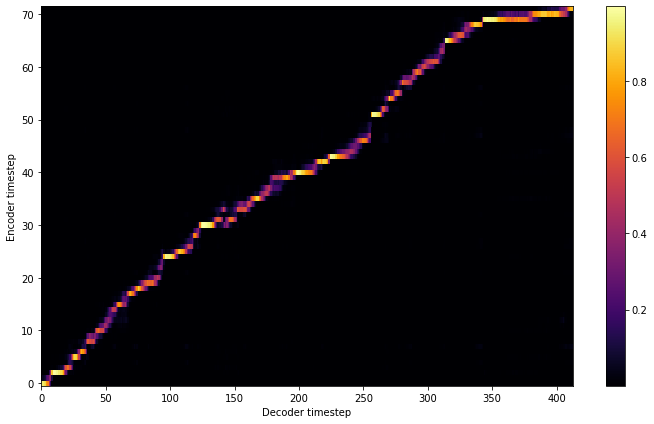